# Desafio Murabei

### Contexto

Esse desafio é parte do processo de seleção para o cargo de Cientista de Dados da empresa Murabei. Os dados foram disponibilizados via email, assim como o texto com a explicação do desafio.


**Objetivo Geral**: Prever o resultado no exame normalizado(variável normexam), a partir de características dos alunos e das escolas. O modelo deve ser capaz de responder quais do tipo de escola (gênero misto, só de homens ou só de mulheres) é mais eficiente na formação de seus alunos de acordo com o resultado do exame normalizado.


**Objetivo do Notebook 3**: Desenvolvimento do modelo, análise das métricas e conclusão do desafio.


**Passos**:

 - [X] Recuperação dos dados limpos e tratados;
 - [X] Transformação das variáveis categóricas;
 - [X] Modelagem;
 - [X] Treinamento e Teste;
 - [X] Análise das métricas;
 - [X] Conclusão;

# Bibliotecas

In [1]:
!pip install lightgbm -q

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import pandas as pd

sys.path.append(os.path.abspath(os.path.pardir))
from src import settings, personalized_functions

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display
from itertools import chain,cycle
from IPython.display import display_html, Math, Latex

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline 
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 150)

## Leitura de dados

In [3]:
# Criar estrutura de diretórios, caso não exista
if not os.path.exists(settings.DATA_PATH):
    os.makedirs(settings.DATA_PATH)


PATH = os.path.join(settings.DATA_PATH)

In [4]:
school_student_df = pd.read_csv(f'{PATH}/clean_data.csv')

In [5]:
school_student_df.head()

,school,schgend,type,schavg,student,intake,sex,vr,normexam,standLRT
0,1,mixed,Mxd,0.166175,1,bottom 25%,F,mid 50%,1.506185,0.784362
1,1,mixed,Mxd,0.166175,4,mid 50%,F,mid 50%,-0.555112,-1.033970
2,1,mixed,Mxd,0.166175,6,mid 50%,M,mid 50%,-1.335315,-0.951318
3,1,mixed,Mxd,0.166175,7,top 25%,M,mid 50%,-0.555112,-2.356393
4,1,mixed,Mxd,0.166175,13,mid 50%,M,mid 50%,-0.197611,-0.290107


## Transformação das variáveis categóricas

In [6]:
categorical_data = school_student_df.select_dtypes(exclude=[np.number])
numerical_data = school_student_df.select_dtypes(include=[np.number])

In [7]:
dummies_categorical_data = pd.get_dummies(categorical_data)
dummies_categorical_data.head()

,schgend_boys,schgend_girls,schgend_mixed,type_Mxd,type_Sngl,intake_bottom 25%,intake_mid 50%,intake_top 25%,sex_F,sex_M,vr_bottom 25%,vr_mid 50%,vr_top 25%
0,0,0,1,1,0,1,0,0,1,0,0,1,0
1,0,0,1,1,0,0,1,0,1,0,0,1,0
2,0,0,1,1,0,0,1,0,0,1,0,1,0
3,0,0,1,1,0,0,0,1,0,1,0,1,0
4,0,0,1,1,0,0,1,0,0,1,0,1,0


In [8]:
final_df = pd.concat([numerical_data, dummies_categorical_data], axis=1)

In [9]:
final_df.head()

,school,schavg,student,normexam,standLRT,schgend_boys,schgend_girls,schgend_mixed,type_Mxd,type_Sngl,intake_bottom 25%,intake_mid 50%,intake_top 25%,sex_F,sex_M,vr_bottom 25%,vr_mid 50%,vr_top 25%
0,1,0.166175,1,1.506185,0.784362,0,0,1,1,0,1,0,0,1,0,0,1,0
1,1,0.166175,4,-0.555112,-1.033970,0,0,1,1,0,0,1,0,1,0,0,1,0
2,1,0.166175,6,-1.335315,-0.951318,0,0,1,1,0,0,1,0,0,1,0,1,0
3,1,0.166175,7,-0.555112,-2.356393,0,0,1,1,0,0,0,1,0,1,0,1,0
4,1,0.166175,13,-0.197611,-0.290107,0,0,1,1,0,0,1,0,0,1,0,1,0


### Correlação das variáveis

In [10]:
final_df.corr()

,school,schavg,student,normexam,standLRT,schgend_boys,schgend_girls,schgend_mixed,type_Mxd,type_Sngl,intake_bottom 25%,intake_mid 50%,intake_top 25%,sex_F,sex_M,vr_bottom 25%,vr_mid 50%,vr_top 25%
school,1.000000,-0.226519,0.029560,-0.049096,-0.071576,0.189490,-0.044102,-0.084961,-0.084961,0.084961,-0.068361,0.027616,0.051509,-0.098590,0.098590,0.016761,0.206169,-0.239515
schavg,-0.226519,1.000000,-0.116092,0.282378,0.312182,-0.001094,0.024798,-0.022853,-0.022853,0.022853,0.199871,-0.057826,-0.184219,0.040104,-0.040104,-0.708554,-0.162411,0.746433
student,0.029560,-0.116092,1.000000,-0.038841,-0.037103,0.116328,0.016742,-0.093832,-0.093832,0.093832,-0.041590,0.025700,0.018282,0.012652,-0.012652,-0.133598,0.219166,-0.133160
normexam,-0.049096,0.282378,-0.038841,1.000000,0.588826,0.008850,0.104164,-0.105000,-0.105000,0.105000,0.467402,-0.167127,-0.384003,0.107485,-0.107485,-0.176719,-0.065957,0.214073
standLRT,-0.071576,0.312182,-0.037103,0.588826,1.000000,-0.000776,0.006433,-0.005599,-0.005599,0.005599,0.586526,-0.182678,-0.521545,0.046523,-0.046523,-0.224475,-0.046982,0.231573
schgend_boys,0.189490,-0.001094,0.116328,0.008850,-0.000776,1.000000,-0.277216,-0.406065,-0.406065,0.406065,0.019742,-0.041922,0.034925,-0.470087,0.470087,0.036790,0.011210,-0.041802
schgend_girls,-0.044102,0.024798,0.016742,0.104164,0.006433,-0.277216,1.000000,-0.765461,-0.765461,0.765461,-0.006164,0.024828,-0.028125,0.589712,-0.589712,-0.020837,-0.046599,0.067811
schgend_mixed,-0.084961,-0.022853,-0.093832,-0.105000,-0.005599,-0.406065,-0.765461,1.000000,1.000000,-1.000000,-0.007359,0.004462,0.003360,-0.246056,0.246056,-0.004821,0.036814,-0.036500
type_Mxd,-0.084961,-0.022853,-0.093832,-0.105000,-0.005599,-0.406065,-0.765461,1.000000,1.000000,-1.000000,-0.007359,0.004462,0.003360,-0.246056,0.246056,-0.004821,0.036814,-0.036500
type_Sngl,0.084961,0.022853,0.093832,0.105000,0.005599,0.406065,0.765461,-1.000000,-1.000000,1.000000,0.007359,-0.004462,-0.003360,0.246056,-0.246056,0.004821,-0.036814,0.036500


## Transformação das variáveis Numéricas

In [11]:
final_df = final_df.drop(columns=['school','student'],axis=1)

In [12]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(final_df)
scaled_df = pd.DataFrame(scaled, columns = final_df.columns)

In [13]:
scaled_df.corr()

,schavg,normexam,standLRT,schgend_boys,schgend_girls,schgend_mixed,type_Mxd,type_Sngl,intake_bottom 25%,intake_mid 50%,intake_top 25%,sex_F,sex_M,vr_bottom 25%,vr_mid 50%,vr_top 25%
schavg,1.000000,0.282378,0.312182,-0.001094,0.024798,-0.022853,-0.022853,0.022853,0.199871,-0.057826,-0.184219,0.040104,-0.040104,-0.708554,-0.162411,0.746433
normexam,0.282378,1.000000,0.588826,0.008850,0.104164,-0.105000,-0.105000,0.105000,0.467402,-0.167127,-0.384003,0.107485,-0.107485,-0.176719,-0.065957,0.214073
standLRT,0.312182,0.588826,1.000000,-0.000776,0.006433,-0.005599,-0.005599,0.005599,0.586526,-0.182678,-0.521545,0.046523,-0.046523,-0.224475,-0.046982,0.231573
schgend_boys,-0.001094,0.008850,-0.000776,1.000000,-0.277216,-0.406065,-0.406065,0.406065,0.019742,-0.041922,0.034925,-0.470087,0.470087,0.036790,0.011210,-0.041802
schgend_girls,0.024798,0.104164,0.006433,-0.277216,1.000000,-0.765461,-0.765461,0.765461,-0.006164,0.024828,-0.028125,0.589712,-0.589712,-0.020837,-0.046599,0.067811
schgend_mixed,-0.022853,-0.105000,-0.005599,-0.406065,-0.765461,1.000000,1.000000,-1.000000,-0.007359,0.004462,0.003360,-0.246056,0.246056,-0.004821,0.036814,-0.036500
type_Mxd,-0.022853,-0.105000,-0.005599,-0.406065,-0.765461,1.000000,1.000000,-1.000000,-0.007359,0.004462,0.003360,-0.246056,0.246056,-0.004821,0.036814,-0.036500
type_Sngl,0.022853,0.105000,0.005599,0.406065,0.765461,-1.000000,-1.000000,1.000000,0.007359,-0.004462,-0.003360,0.246056,-0.246056,0.004821,-0.036814,0.036500
intake_bottom 25%,0.199871,0.467402,0.586526,0.019742,-0.006164,-0.007359,-0.007359,0.007359,1.000000,-0.750508,-0.245116,0.018731,-0.018731,-0.121034,-0.052007,0.154111
intake_mid 50%,-0.057826,-0.167127,-0.182678,-0.041922,0.024828,0.004462,0.004462,-0.004462,-0.750508,1.000000,-0.456739,0.016885,-0.016885,0.008552,0.051373,-0.063192


## Separação em treino e teste

In [14]:
X = scaled_df.drop(columns=['normexam'],axis=1)
y = scaled_df['normexam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Seleção de features

- Usando correlação de Pearson

Correlação é uma medida de como duas variáveis variam juntas. A correlação pode ter uma variação linear, e para esse tipo de variação é utilizado a correlação de Pearson, dada pela equação abaixo:

$$\rho = \frac{\sum_{i=1}^{n}(x_{i}-\overline{x})(y_{i}-\overline{y})}{\sqrt{\sum_{i=1}^{n}(x_{i}-\overline{x})^{2}}\cdot \sqrt{\sum_{i=1}^{n}(y_{i}-\overline{y})^{2}}} = \frac{cov(X,Y)}{\sqrt {var(X)\cdot var(Y)}}$$

onde

$\overline x = \frac{1}{n} \cdot \sum_{i=1}^{n} x_{i}$ e $\overline y = \frac {1}{n} \cdot \sum_{i=1}^{n}  y_{i}$

A correlação varia de +1 a -1, sendo o sinal um indicador de direção, se a correlação é positiva ou negativa e o número indica a força da correlação.

In [15]:
fs_corr = SelectKBest(score_func=f_regression, k='all')
fs_corr.fit(X_train, y_train)
X_train_fs_corr = fs_corr.transform(X_train)
X_test_fs_corr = fs_corr.transform(X_test)
column_names_fs_corr = [column[0]  for column in zip(X_train.columns,fs_corr.get_support()) if column[1]]

In [16]:
fs_corr_df = (pd.DataFrame({'Feature':column_names_fs_corr,'Score':fs_corr.scores_})
             .sort_values(by='Score', ascending=False)
             )

- Usando Informação Mútua

Informação mútua é a medida de dependência mútua entre duas variáveis. É a quantificação de informação que uma variável contém acerca de outra. Para o caso de variáveis contínuas, a informação mútua é dada por:

$$
I(X;Y) = \int_{Y}^{}\int_{X}{}p(x,y)log\left ( \frac{p(x,y)}{p(x)p(y)} \right )dxdy
$$

onde *p(x,y)* é a função de densidade de probabilidade conjunta de *X e Y, p(x)* e *p(y)* são funções de densidade de probabilidade marginal de *X e Y*, respectivamente.

In [17]:
fs_mutual = SelectKBest(score_func=mutual_info_regression, k='all')
fs_mutual.fit(X_train, y_train)
X_train_fs_mutual = fs_mutual.transform(X_train)
X_test_fs_mutual = fs_mutual.transform(X_test)
column_names_fs_mutual = [column[0]  for column in zip(X_train.columns,fs_mutual.get_support()) if column[1]]

In [18]:
fs_mutual_df = (pd.DataFrame({'Feature':column_names_fs_mutual,'Score':fs_mutual.scores_})
                .sort_values(by='Score', ascending=False)
               )

In [19]:
display(HTML('<h2>Comparação entre os métodos utilizados para a seleção de features<h2>'))
personalized_functions.display_side_by_side(fs_corr_df,fs_mutual_df, titles=['Pearson Correlation',
                                                                             'Mutual Information'])


,Feature,Score
1,standLRT,1590.177885
7,intake_bottom 25%,831.841609
9,intake_top 25%,511.785780
0,schavg,267.522835
14,vr_top 25%,144.580701
12,vr_bottom 25%,107.507558
8,intake_mid 50%,88.033917
3,schgend_girls,40.674358
6,type_Sngl,40.172712
4,schgend_mixed,40.172712


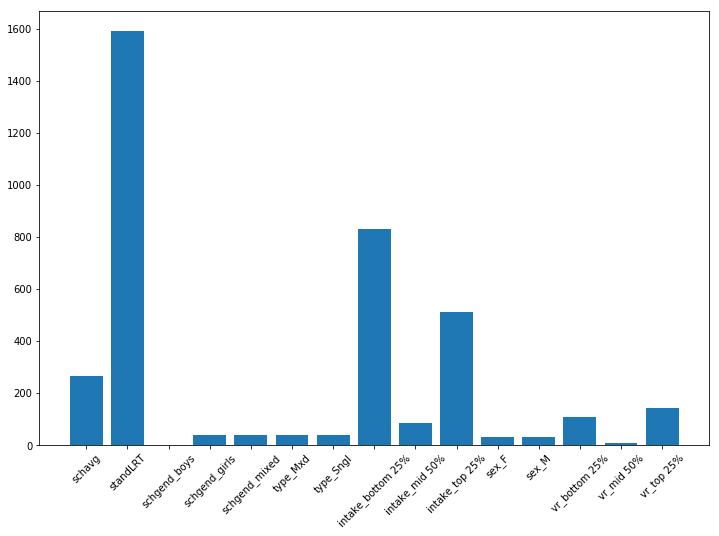

In [20]:
plt.figure(figsize=(12, 8))
plt.bar([column for column in column_names_fs_corr], fs_corr.scores_)
plt.xticks(rotation = 45)
plt.show()

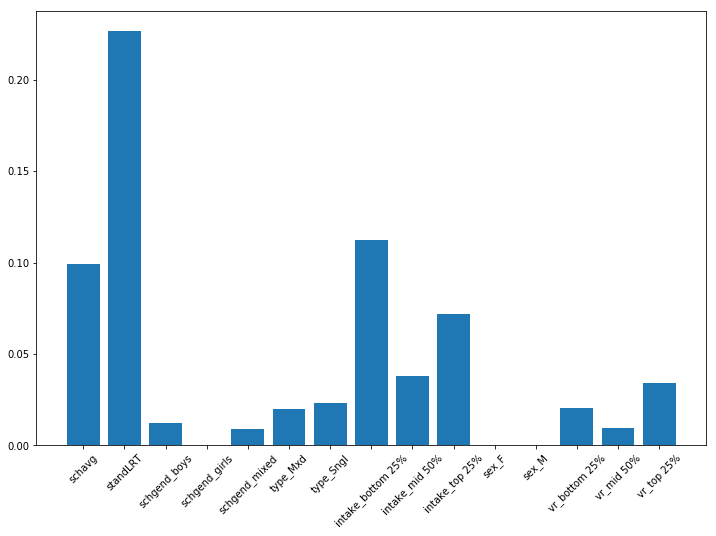

In [21]:
plt.figure(figsize=(12, 8))
plt.bar([column for column in column_names_fs_mutual], fs_mutual.scores_)
plt.xticks(rotation = 45)
plt.show()

## Treinamento do Modelo

- Utilizando as features selecionadas usando a correlação de Pearson

In [22]:
X_fs_train = (X_train[['standLRT','intake_bottom 25%','intake_top 25%','intake_mid 50%', 
                    'schavg','vr_top 25%','vr_bottom 25%']]
          )
X_fs_test = (X_test[['standLRT','intake_bottom 25%','intake_top 25%','intake_mid 50%', 
                    'schavg','vr_top 25%','vr_bottom 25%']]
          )

- Regressão Linear

In [23]:
linear_model = LinearRegression()
linear_model.fit(X_fs_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [24]:
print(linear_model.intercept_)
print(linear_model.coef_)

0.28783815851837047
[ 0.3118099   0.05435966 -0.05075007 -0.00360959  0.09521201 -0.00719898
  0.01878465]


In [25]:
y_pred = linear_model.predict(X_fs_test)

In [26]:
df_test = pd.DataFrame({'Real': y_test, 'Predicted': y_pred})
df_test.head()

,Real,Predicted
3399,0.394149,0.425095
1114,0.442744,0.571624
351,0.554917,0.528147
3401,0.404596,0.360632
2322,0.500588,0.494617


 - LightGBM Regressor

In [27]:
lightgbm_model = LGBMRegressor(random_state=42)
lightgbm_model.fit(X_fs_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [28]:
y_pred_lightgbm_model = lightgbm_model.predict(X_fs_test)

In [29]:
df_test_lightgbm_model = pd.DataFrame({'Real': y_test, 'Predicted': y_pred_lightgbm_model})
df_test_lightgbm_model.head()

,Real,Predicted
3399,0.394149,0.478116
1114,0.442744,0.498426
351,0.554917,0.567557
3401,0.404596,0.393730
2322,0.500588,0.491629


### Métricas

- **Mean Absolute Error (MAE)**

O erro absoluto médio representa a média da diferença absoluta entre os valores reais e previstos no conjunto de dados. Ele mede a média dos resíduos no conjunto de dados.

$$
MAE = \frac{1}{n}\sum_{j=1}^{n}\left|y_{j} - \widehat{y_{j}} \right|
$$

- **Mean Squarred Error (MSE)**

O Erro Quadrado Médio representa a média da diferença quadrada entre os valores original e previsto no conjunto de dados. Ele mede a variância dos resíduos.

$$
MSE = \frac{1}{n}\sum_{j=1}^{n}\left(y_{j} - \widehat{y_{j}} \right)^{2}
$$

- **Root Mean Squarred Error (RMSE)**

O erro quadrático médio é a raiz quadrada do erro quadrático médio. Ele mede o desvio padrão dos resíduos.

$$
RMSE = \sqrt{\frac{1}{n}\sum_{j=1}^{n}\left(y_{j} - \widehat{y_{j}} \right)^{2}}
$$

 - **Coeficiente de Determinação (R²)**
 
O coeficiente de determinação ou R² representa a proporção da variância na variável dependente que é explicada pelo modelo de regressão linear. É uma pontuação sem escala, ou seja, independentemente dos valores serem pequenos ou grandes, o valor de R quadrado será menor que um.

 $$R^2(y, \hat{y}) = 1 - \frac {\sum_{i=0}^{n-1}(y_i-\hat{y}_i)^2}{\sum_{i=0}^{n-1}(y_i-\bar{y}_i)^2}$$

- Regressão Linear

In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R² Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.08923849322224488
Mean Squared Error: 0.012634383679156024
Root Mean Squared Error: 0.11240277433923072
R² Score: 0.38369360772900374


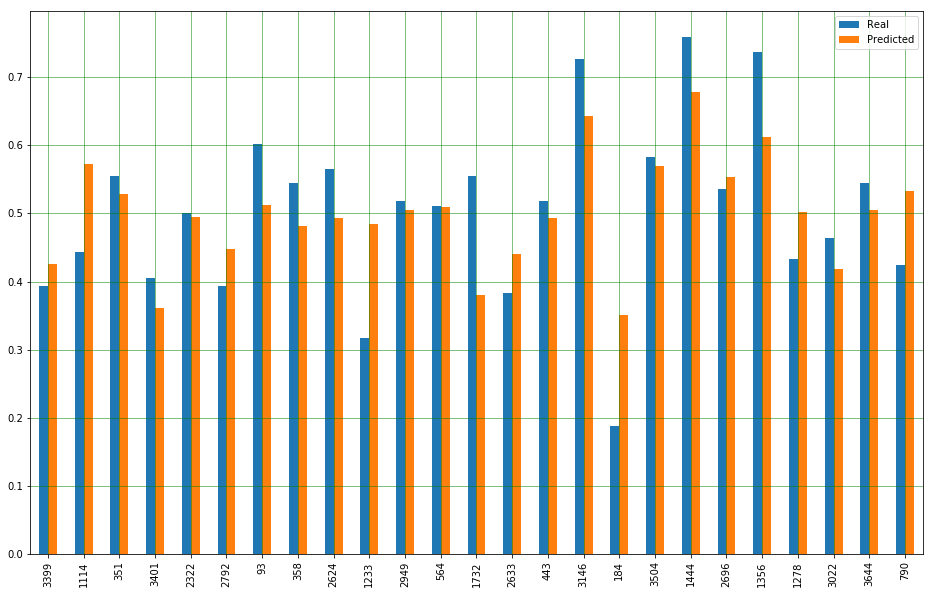

In [31]:
df1 = df_test.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

- LightGBM Regressor

In [32]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lightgbm_model))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lightgbm_model))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lightgbm_model)))
print('R² Score:', metrics.r2_score(y_test, y_pred_lightgbm_model))

Mean Absolute Error: 0.08670859293980221
Mean Squared Error: 0.01194400049124253
Root Mean Squared Error: 0.1092886109859693
R² Score: 0.4173705628249198


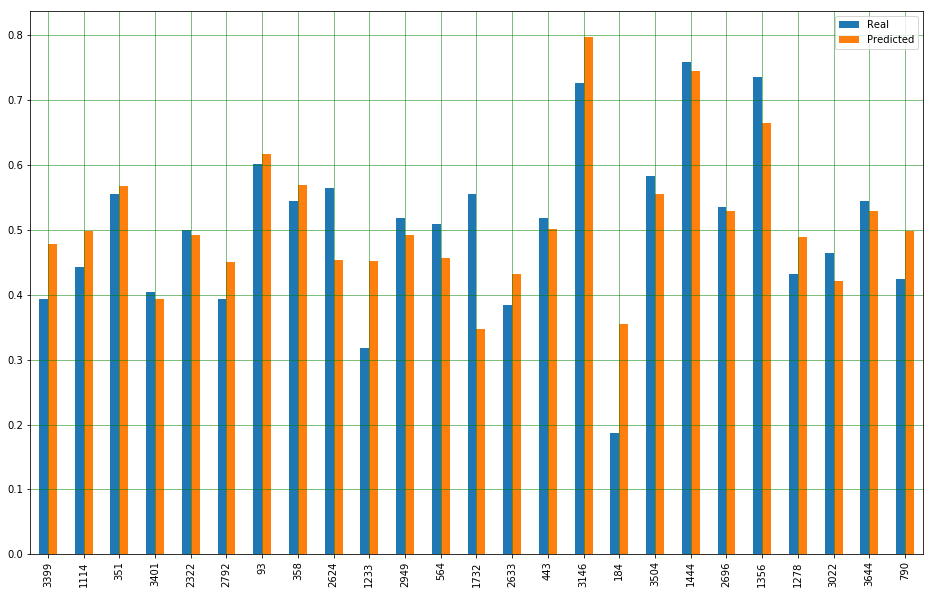

In [33]:
df1 = df_test_lightgbm_model.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Conclusão

Para determinar qual tipo de escola é mais eficiente, foi executado no Notebook 2 alguns testes de hipóteses acerca da média da distribuição da nota normalizada do exame. Segundo os testes, o tipo de escola mais eficiente são as escolas de gênero único.

Foi desenvolvido no notebook 3, um modelo de regressão linear e um modelo de árvore de decisão para prever a variável alvo (nota normalizada do exame). Ambos os modelos tiveram um coeficiente de determinação baixo, mesmo quando selecionadas as features mais informativas. Porém, o erro absoluto, a variância e o desvio padrão dos resíduos, ficaram baixos, o que é bom para o modelo. 

Algumas alternativas para melhorar a performance do modelo seriam:

- Utilizar um conjunto de dados maior;
- Fazer tunning de hiperparâmetros do modelo;
- Inserir outras features no modelo;

Como ambos os modelos mostraram resultados bem próximos, sempre devemos escolher o modelo mais simples (no caso, o modelo de regressão linear), por conta da explicabilidade do modelo.